# Import libs

In [85]:
import numpy as np
import pandas as pd
import matplotlib.backends.backend_pdf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import scanpy as sc
import anndata as ad
import tangram as tg
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
np.random.seed(10)

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,5]

In [3]:
import torch
torch.cuda.empty_cache()
device = torch.device("cpu")

In [4]:
# project_location = "e:/projects/stloc/"
project_location = "./"

# Load data

## Spatial data

In [5]:
df_st = pd.read_csv(project_location + "data/merfish/merfishSpatial.csv", sep=" ")
coords = df_st['coord']
df_st.drop(columns=['coord'], inplace=True)
cellTypeCount =16
typeCountDf=  df_st.iloc[:,-cellTypeCount:]
# df_st = df_st.iloc[: , :-cellTypeCount]
df_st.head()

,Ace2,Adora2a,Aldh1l1,Amigo2,Ano3,Aqp4,Ar,Arhgap36,Avpr1a,Avpr2,...,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0.000000,0.631323,2.783859,4.017283,0.707772,2.754597,1.262664,14.922339,0.707772,0.0,...,0,0,0,1,1,0,0,0,0,0
1,0.000000,0.000000,5.027816,0.000000,0.000000,10.056050,0.000000,0.000000,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,3.856702,0.000000,0.854257,0.427118,0.0,...,0,0,0,1,1,0,0,0,0,0
3,0.000000,0.000000,1.465245,0.732607,0.000000,2.323503,0.795436,0.732607,0.732607,0.0,...,0,0,0,2,0,0,0,0,0,0
4,6.311896,7.574326,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,1,0,0,1,0,0,0,0


In [6]:
typeCountDf.head()

,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [7]:
reference = pd.read_csv(project_location + "data/merfish/markerGene_for_merfish_data.csv")

reference.drop(columns=['p_value'], inplace=True)
# reference.drop(range(148,168))
reference.drop(reference.index[reference.cell_type=='EpendymalInhibitory'].tolist(), inplace=True)
reference['cell_type'] = reference['cell_type'].astype(str).str.replace(" ", "")
reference.head()

,cell_type,marker_gene
0,Astrocyte,Aldh1l1
1,Astrocyte,Aqp4
2,Astrocyte,Cxcl14
3,Astrocyte,Mlc1
4,Astrocyte,Ttyh2


In [8]:
genes = df_st.columns[:155]
markers = reference.groupby('cell_type').agg(list).marker_gene
celltypes = reference.cell_type.unique().tolist()
expressions = df_st.drop(columns=celltypes)
expressions = MinMaxScaler().fit_transform(expressions)
counts_st = pd.DataFrame(expressions, columns=genes)
cellcount = pd.DataFrame(np.sum(df_st[celltypes], axis=1), columns=['cellcount'])

In [9]:
print(cellcount)
zero = (cellcount==0).sum()
print('zero count is',zero)
len(celltypes)

      cellcount
0             4
1             1
2             2
3             2
4             2
...         ...
1244          4
1245          1
1246          3
1247          5
1248          1

[1249 rows x 1 columns]
zero count is cellcount    0
dtype: int64


16

## Single-cell data

In [10]:
df_sc = pd.read_csv(project_location + "data/merfish/merfishVisium.csv")

In [11]:
counts_sc = df_sc[genes]
obs_sc = df_sc[[x for x in df_sc.columns if x not in genes]]
obs_sc.head()

,Cell_ID,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID
0,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
1,b13e98f4-5c2b-4e96-985e-3e93aedc7221,1,Female,Naive,-0.24,-3746.226210,-3742.259347,Inhibitory,I-1
2,d06cb29e-10ee-4bbc-b74e-90237999ef4b,1,Female,Naive,-0.24,-3742.897643,-3790.648737,Inhibitory,I-13
3,12e2a165-57c7-4f37-96dd-23f6574af4ba,1,Female,Naive,-0.24,-3738.423005,-3773.259265,Inhibitory,I-19
4,14a0f396-b13d-4d45-89a3-86c2047bf3f9,1,Female,Naive,-0.24,-3736.407620,-3895.590306,Pericytes,NaN


In [12]:
obs_sc.shape
obs_sc.loc[0,"Cell_class"]

'Astrocyte'

# Tangram

In [13]:
adata_sc = ad.AnnData(counts_sc)
adata_st = ad.AnnData(counts_st, obs=cellcount)
print(adata_sc.shape)
print(adata_st.shape)

(6412, 155)
(1249, 155)


In [14]:
adata_st.obs.head()
zeroCount=(obs_sc["Cell_class"]==0).sum()
zeroCount

0

In [15]:
tg.pp_adatas(adata_sc, adata_st, genes=None)

INFO:root:155 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:155 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [16]:
# adata_map_rna = tg.map_cells_to_space(adata_sc, adata_st, device=device, num_epochs=500)

In [17]:
adata_map_cellcount = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    target_count=adata_st.obs.cellcount.sum(),
    density_prior=np.array(adata_st.obs.cellcount) / adata_st.obs.cellcount.sum(),
    device=device,
    num_epochs=500
)
probabilityDf= adata_map_cellcount.to_df()

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 155 genes and customized density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.508, KL reg: 0.107
Score: 0.986, KL reg: 0.000
Score: 0.990, KL reg: 0.000
Score: 0.991, KL reg: 0.000
Score: 0.991, KL reg: 0.000


INFO:root:Saving results..


In [18]:
probabilityDf.shape

(6412, 1249)

# probability analysis

In [96]:
np.argmax(probabilityDf.iloc[2])
# probabilityDf.iloc[2,1247]

Nrows= len(df_st)
Ncols= len(celltypes)

deconvDf = pd.DataFrame(np.zeros((Nrows,Ncols)),columns=celltypes)
for i in range(len(probabilityDf)):
    spotNo = np.argmax(probabilityDf.iloc[i])
    cellClass= obs_sc.loc[i,"Cell_class"]
    deconvDf.loc[spotNo,cellClass] = deconvDf.loc[spotNo,cellClass] +1


deconvDf = deconvDf.astype(int)
deconvolveDf = deconvDf.copy()
deconvDf.shape

(1249, 16)

In [20]:
deconvDf.head()

,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [21]:
for i in range(len(deconvDf)):
    deconvolveDf.iloc[i] = 100 * deconvDf.iloc[i]/deconvDf.iloc[i].sum()

In [22]:
print(deconvolveDf.head())
deconvolveDf.to_csv("tangramDeconvolved.csv",index= False)
deconvolveDf.isnull().sum(axis = 0)

   Astrocyte  Inhibitory  Pericytes  Ambiguous  Endothelial1  Excitatory  \
0        0.0        30.0        0.0   0.000000          10.0         0.0   
1        0.0         0.0        0.0  50.000000           0.0         0.0   
2        0.0         0.0        0.0   0.000000           0.0         0.0   
3        0.0         0.0        0.0  33.333333           0.0         0.0   
4        0.0         0.0        0.0   0.000000          25.0         0.0   

   ODImmature1  ODImmature2  Microglia  ODMature2  ODMature1  Endothelial3  \
0          0.0          0.0        0.0  40.000000       20.0           0.0   
1          0.0          0.0        0.0  50.000000        0.0           0.0   
2          0.0          0.0        0.0  75.000000       25.0           0.0   
3          0.0          0.0        0.0  66.666667        0.0           0.0   
4          0.0          0.0       25.0   0.000000       25.0          25.0   

   ODMature3  ODMature4  Endothelial2  Ependymal  
0        0.0        0.0

Astrocyte       0
Inhibitory      0
Pericytes       0
Ambiguous       0
Endothelial1    0
Excitatory      0
ODImmature1     0
ODImmature2     0
Microglia       0
ODMature2       0
ODMature1       0
Endothelial3    0
ODMature3       0
ODMature4       0
Endothelial2    0
Ependymal       0
dtype: int64

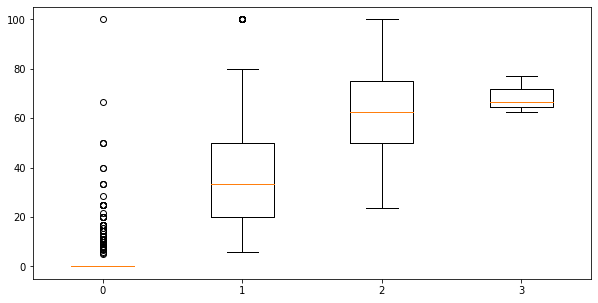

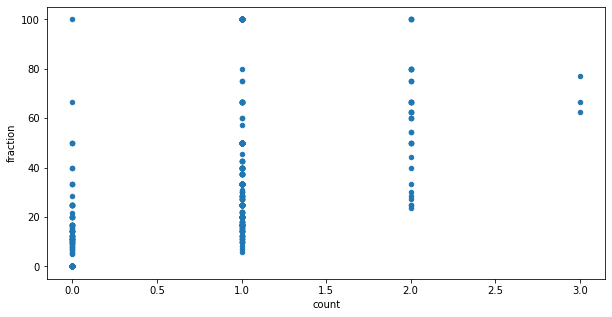

In [59]:
# cellDict={}
# for  c in ['Astrocyte']:
#     uniqueCounts= (typeCountDf[c].unique())
#     uniqueCounts = np.sort(uniqueCounts)
#     for val in uniqueCounts:
#         cellDict[val]=[deconvolveDf.iloc[Index][c] for Index  in range(len(deconvolveDf))  if abs(typeCountDf.iloc[Index][c]-val)<0.0000001 ]
#     # print(cellDict[0])

#     fig, ax  = plt.subplots()
#     ax.boxplot(cellDict.values())
#     ax.set_xticklabels(cellDict.keys())

#     scatterDict={
#         "count": typeCountDf[c],
#         "fraction":deconvolveDf[c],
#     }
#     scatterDf=pd.DataFrame(scatterDict)   
#     ax1 = scatterDf.plot.scatter(x='count',
#                       y='fraction',
#                     )
#     # pdf = matplotlib.backends.backend_pdf.PdfPages("./output/merfish/tangram2c"+c+".pdf")
#     # pdf.savefig(ax)
#     # pdf.savefig(ax1)

# Spatial data exploration

In [24]:
for i in range(deconvolveDf.shape[0]):
    for j in range(deconvolveDf.shape[1]):
        # if celltype-specific cellcount is zero and deconvolution percentage > threshold
        if typeCountDf.iloc[i,j] == 0 and deconvolveDf.iloc[i,j] > 25:
            print(cellcount.iloc[i][0], deconvolveDf.columns[j], deconvolveDf.iloc[i,j])

1 Ambiguous 50.0
2 Ambiguous 33.333333333333336
1 Ambiguous 66.66666666666667
4 Excitatory 33.333333333333336
2 Astrocyte 33.333333333333336
2 Inhibitory 28.571428571428573
1 Inhibitory 33.333333333333336
1 Inhibitory 40.0
1 Ambiguous 50.0
1 Excitatory 50.0
1 Ambiguous 50.0
2 Ambiguous 33.333333333333336
1 Ambiguous 66.66666666666667
2 Inhibitory 33.333333333333336
3 ODMature1 40.0
2 ODImmature1 33.333333333333336
2 Ambiguous 33.333333333333336
2 Ambiguous 33.333333333333336
2 Ambiguous 40.0
1 Astrocyte 50.0
2 Inhibitory 50.0
3 Inhibitory 40.0
2 ODMature2 33.333333333333336
2 Inhibitory 33.333333333333336
2 Astrocyte 50.0
3 Astrocyte 28.571428571428573
3 Excitatory 40.0
2 Excitatory 33.333333333333336
2 Inhibitory 33.333333333333336
1 Ambiguous 50.0
2 Astrocyte 33.333333333333336
2 Excitatory 33.333333333333336
2 Ambiguous 33.333333333333336
2 Excitatory 33.333333333333336
1 Astrocyte 50.0
1 Astrocyte 66.66666666666667
1 Excitatory 33.333333333333336
1 Ambiguous 50.0
1 Ambiguous 33.333

In [25]:
cellcount.value_counts()

cellcount
2            363
3            350
1            224
4            207
5             78
6             24
7              2
8              1
dtype: int64

In [153]:
l = np.max(cellcount.values) + 1
count_misprediction = dict.fromkeys(celltypes)
for i in count_misprediction:
    count_misprediction[i] = dict.fromkeys(range(l))
    for j in count_misprediction[i]:
        count_misprediction[i][j] = [0,0]

for j in range(deconvDf.shape[1]):
    for i in range(deconvDf.shape[0]):
        actual_count = typeCountDf.iloc[i,j]
        predicted_count = deconvDf.iloc[i,j]
        count_misprediction[deconvDf.columns[j]][typeCountDf.iloc[i,j]][0] += 1
        if typeCountDf.iloc[i,j] != deconvDf.iloc[i,j]:
            count_misprediction[deconvDf.columns[j]][typeCountDf.iloc[i,j]][1] += 1
count_misprediction

{'Astrocyte': {0: [914, 79],
  1: [292, 141],
  2: [40, 33],
  3: [3, 3],
  4: [0, 0],
  5: [0, 0],
  6: [0, 0],
  7: [0, 0],
  8: [0, 0]},
 'Inhibitory': {0: [534, 80],
  1: [391, 184],
  2: [217, 159],
  3: [86, 82],
  4: [16, 16],
  5: [3, 3],
  6: [1, 1],
  7: [1, 1],
  8: [0, 0]},
 'Pericytes': {0: [1233, 11],
  1: [9, 5],
  2: [1, 1],
  3: [6, 6],
  4: [0, 0],
  5: [0, 0],
  6: [0, 0],
  7: [0, 0],
  8: [0, 0]},
 'Ambiguous': {0: [850, 166],
  1: [328, 104],
  2: [63, 37],
  3: [8, 5],
  4: [0, 0],
  5: [0, 0],
  6: [0, 0],
  7: [0, 0],
  8: [0, 0]},
 'Endothelial1': {0: [1109, 31],
  1: [129, 62],
  2: [9, 8],
  3: [1, 1],
  4: [1, 1],
  5: [0, 0],
  6: [0, 0],
  7: [0, 0],
  8: [0, 0]},
 'Excitatory': {0: [753, 97],
  1: [374, 177],
  2: [97, 76],
  3: [20, 18],
  4: [5, 5],
  5: [0, 0],
  6: [0, 0],
  7: [0, 0],
  8: [0, 0]},
 'ODImmature1': {0: [1139, 31],
  1: [107, 49],
  2: [3, 2],
  3: [0, 0],
  4: [0, 0],
  5: [0, 0],
  6: [0, 0],
  7: [0, 0],
  8: [0, 0]},
 'ODImmature2

In [135]:
z = 0
for i in count_misprediction:
    z += count_misprediction[i][0][1]
    
z, deconvDf.shape, (z / np.prod(deconvDf.shape)) * 100

(597, (1249, 16), 2.9873899119295437)

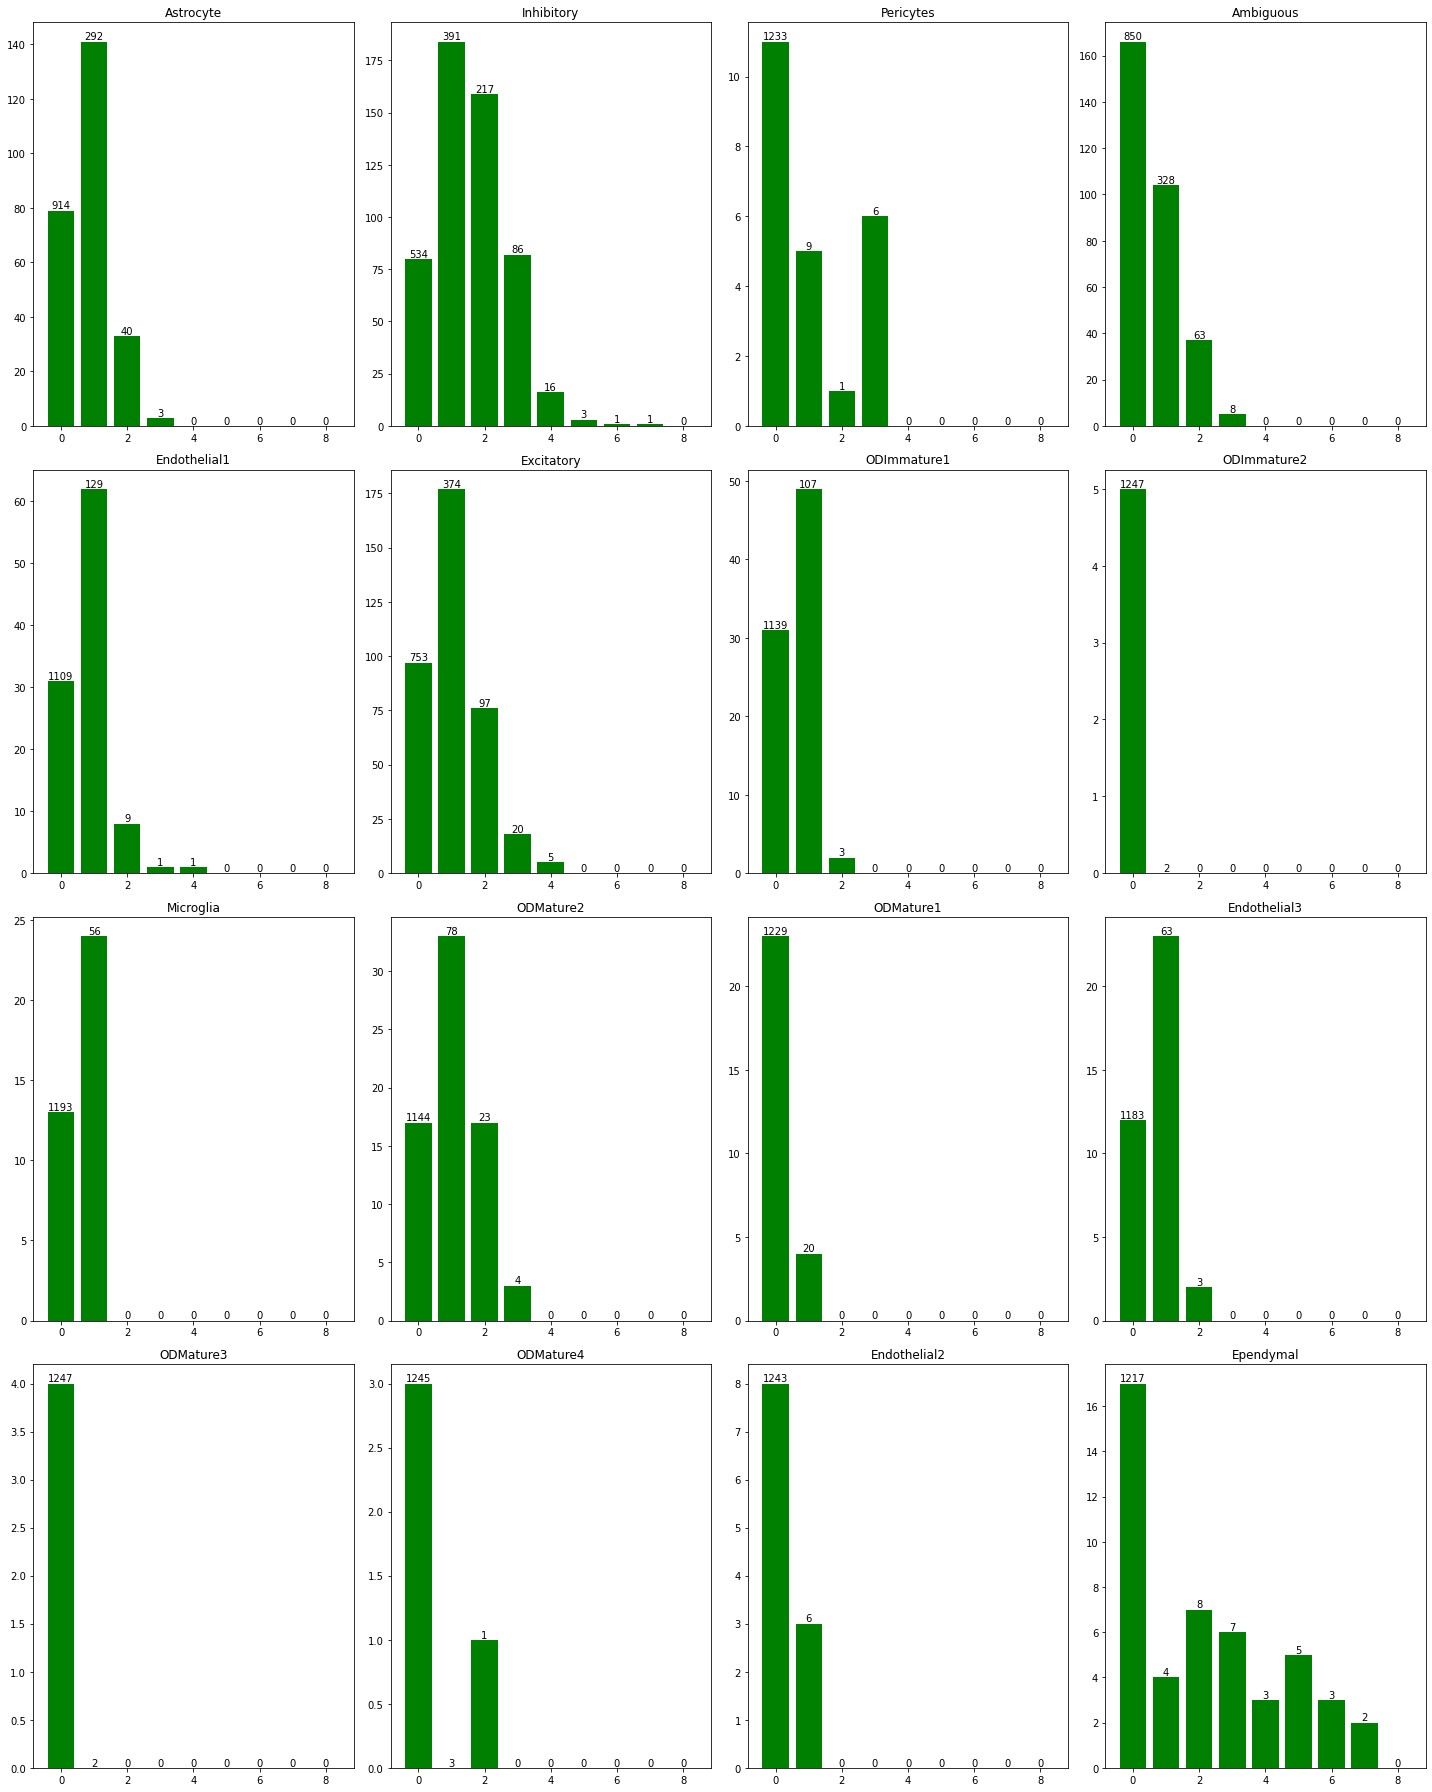

In [185]:
plt.rcParams['figure.figsize'] = [20,25]

for i, celltype in enumerate(celltypes):
    x = list(count_misprediction[celltype].keys())
    y = np.array(list(count_misprediction[celltype].values()))
    plt.subplot(4, 4, i+1)
    bar = plt.bar(x, y[:,1], width=0.8, color='g')
    for j, rect in enumerate(bar):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{y[j,0]:.0f}', ha='center', va='bottom')
    plt.title(celltype)
    # plt.legend()
    # plt.subplots_adjust(hspace = 0.4)
    plt.tight_layout()
    
plt.rcParams['figure.figsize'] = [10,5]

In [149]:
z = np.array(list(count_misprediction[celltype].values()))
z[:,0]

array([914, 292,  40,   3,   0,   0,   0,   0,   0])

In [160]:
x = list(count_misprediction['Astrocyte'].keys())
[i-0.4 for i in x]

[-0.4, 0.6, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6, 7.6]